# TODO

- []: Remove unnecessary columns
- [X]: Check for movies with same name
    - [X]: Solution: use date and duration to cross check between datasets
- []: Create unified id
    - [X]: Remove duplicate ids from TMDb
    - [X]: Remove duplicate names and titles (AGAIN!!) from both df's
    - []: Same name, same runtime, different year
        - []: Some are in fact the same movie
        - []: Others are not the same movie
        - []: Potential solution: keep earliest and latest dates in letterboxd
- [X]: Fix missing dates
    - [X]: Missing in letterboxd and found in TMDb
    - [X]: Missing in letterboxd and found in releases.csv
    - [X]: Missing in TMDb and found in letterboxd
- [X]: Mismatch in names
    - [X]: Solution: match by year and duration and check string similarity

In [445]:
import pandas as pd
from rapidfuzz import fuzz
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = './data'
REPLICATION = False

### Combine actors df and crew df

In [446]:
if REPLICATION:
    cast = pd.read_csv(BASE_DIR + '/actors.csv')
    crew = pd.read_csv(BASE_DIR + '/crew.csv')

    cast['member'] = 'Cast'
    crew['member'] = 'Crew'

    cast = cast[['id', 'name', 'member', 'role']]
    crew = crew[['id', 'name', 'member', 'role']]

    cast_crew = pd.concat([cast, crew], axis=0, ignore_index=True)
    cast_crew.to_csv('./output/cast_crew.csv', index=False)

In [447]:
progress_l = []
action_l = []
l_step = 0
progress_t = []
action_t = []
t_step = 0

In [448]:
def mark_progress(df: pd.DataFrame, name: str, action: str) -> None:
    global progress_l
    global action_l
    global l_step
    
    global progress_t
    global action_t
    global t_step
    
    if name == 'l':
        progress_l.append(df.shape[0])
        action_l.append(action)
        l_step += 1
    elif name == 't':
        progress_t.append(df.shape[0])
        action_t.append(action)
        t_step += 1
    else:
        print('Wrong name')

# Letterboxd movie dataset

In [449]:
dtypes = {'id': pd.Int32Dtype(), 'name': pd.StringDtype(), 'tagline': pd.StringDtype(), 'description': pd.StringDtype(), 'minute': pd.Int32Dtype(), 'rating': pd.Float64Dtype()}

In [450]:
letterboxd = pd.read_csv(BASE_DIR + '/movies.csv', dtype=dtypes, parse_dates=['date'])
letterboxd.drop(columns={'tagline', 'description'}, inplace=True)
#We'll replace all dates with either their releases.csv equivalent or their TMDb equivalent.
letterboxd['date'] = pd.NaT
letterboxd
mark_progress(letterboxd, 'l', 'original file')

### Short films

In [451]:
letterboxd = letterboxd[letterboxd.minute >= 30]
mark_progress(letterboxd, 'l', 'removed short films')

### No names available

In [452]:
letterboxd[letterboxd.name.isna()]

,id,name,date,minute,rating
741481,1741482,<NA>,NaT,90,<NA>


In [453]:
letterboxd.dropna(subset=['name'], inplace=True)
mark_progress(letterboxd, 'l', 'no movie name')

### No dates available. 

- We'll attempt to handle this issue by comparing with the releases.csv file.

In [454]:
letterboxd[letterboxd.date.isna()]

,id,name,date,minute,rating
0,1000001,Barbie,NaT,114,3.86
1,1000002,Parasite,NaT,133,4.56
2,1000003,Everything Everywhere All at Once,NaT,140,4.3
3,1000004,Fight Club,NaT,139,4.27
4,1000005,La La Land,NaT,129,4.09
...,...,...,...,...,...
941587,1941588,日本統一61,NaT,70,<NA>
941588,1941589,末日审判,NaT,63,<NA>
941593,1941594,蟲極道蜜団子抗争編 壱ノ巻,NaT,30,<NA>
941594,1941595,蟲極道蜜団子抗争編 弐ノ巻,NaT,30,<NA>


- Firstly we'll replace all dates with their releases counterpart.

In [455]:
releases = pd.read_csv(BASE_DIR + '/releases.csv', parse_dates=['date'])

In [456]:
earliest_release_date = releases.groupby('id').date.min().to_frame().reset_index()

In [457]:
pd.merge(letterboxd, earliest_release_date, on='id', how='right', suffixes=['_letterboxd', '_release'])

,id,name,date_letterboxd,minute,rating,date_release
0,1000001,Barbie,NaT,114,3.86,2023-07-06
1,1000002,Parasite,NaT,133,4.56,2019-05-21
2,1000003,Everything Everywhere All at Once,NaT,140,4.3,2022-03-11
3,1000004,Fight Club,NaT,139,4.27,1999-09-10
4,1000005,La La Land,NaT,129,4.09,2016-08-31
...,...,...,...,...,...,...
826013,1940967,<NA>,NaT,<NA>,<NA>,1909-01-01
826014,1940968,<NA>,NaT,<NA>,<NA>,1908-11-11
826015,1940969,<NA>,NaT,<NA>,<NA>,1902-01-01
826016,1940970,<NA>,NaT,<NA>,<NA>,1902-01-01


In [458]:
mapping = earliest_release_date.set_index('id')['date']

mask = letterboxd.id.isin(earliest_release_date.id)

letterboxd.loc[mask, 'date'] = letterboxd.loc[mask, 'id'].map(mapping)

### Same name

In [459]:
letterboxd = letterboxd.drop_duplicates(subset=['name', 'date'], keep='first')
mark_progress(letterboxd, 'l', 'duplicate names with exact date')

In [460]:
letterboxd[letterboxd.duplicated(subset=['name', 'date'], keep=False)].sort_values(by='name')

,id,name,date,minute,rating


In [461]:
letterboxd

,id,name,date,minute,rating
0,1000001,Barbie,2023-07-06,114,3.86
1,1000002,Parasite,2019-05-21,133,4.56
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3
3,1000004,Fight Club,1999-09-10,139,4.27
4,1000005,La La Land,2016-08-31,129,4.09
...,...,...,...,...,...
941587,1941588,日本統一61,NaT,70,<NA>
941588,1941589,末日审判,NaT,63,<NA>
941593,1941594,蟲極道蜜団子抗争編 壱ノ巻,NaT,30,<NA>
941594,1941595,蟲極道蜜団子抗争編 弐ノ巻,NaT,30,<NA>


In [462]:
letterboxd[letterboxd.duplicated(subset=['name', 'date'], keep=False)].sort_values(by='name')

,id,name,date,minute,rating


In [463]:
letterboxd[letterboxd.duplicated(subset='id', keep=False)]

,id,name,date,minute,rating


# TMDb movie dataset

In [464]:
tmdb = pd.read_csv(BASE_DIR + '/TMDB_movie_dataset_v11.csv', parse_dates=['release_date'])
mark_progress(tmdb, 't', 'original file')

### Short films

In [465]:
tmdb = tmdb[tmdb.runtime >= 30]
mark_progress(tmdb, 't', 'dropped short films')

### Adult films

In [466]:
tmdb = tmdb[~tmdb.adult]
mark_progress(tmdb, 't', 'dropped adult films')

### No name

In [467]:
tmdb.dropna(subset=['title'], inplace=True)
mark_progress(tmdb, 't', 'no movie name')

### No date

In [468]:
tmdb[tmdb.release_date.isna()].shape[0]

45110

### Same name

In [469]:
tmdb = tmdb.drop_duplicates(subset=['title', 'runtime'], keep='first')
mark_progress(tmdb, 't', 'duplicated name with exact runtime')

### Same id

In [470]:
tmdb = tmdb.drop_duplicates(subset=['id'], keep='first')
mark_progress(tmdb, 't', 'duplicated id')

In [471]:
tmdb[tmdb.duplicated(subset=['id'], keep=False)]

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords


### Drop all irrelevant columns from the TMDb dataframe

In [369]:
tmdb = tmdb[['id', 'title', 'vote_average', 'vote_count', 'release_date',
       'revenue', 'runtime', 'budget', 'popularity']]

In [370]:
tmdb_short = tmdb[['id', 'title', 'release_date', 'runtime']].copy()
tmdb_short

,id,title,release_date,runtime
0,27205,Inception,2010-07-15,148
1,157336,Interstellar,2014-11-05,169
2,155,The Dark Knight,2008-07-16,152
3,19995,Avatar,2009-12-15,162
4,24428,The Avengers,2012-04-25,143
...,...,...,...,...
1343071,870714,Come prima,2022-06-16,96
1343078,870721,The German,2018-06-05,57
1343085,259492,Mary's Sons,2002-05-19,100
1343086,870729,Saitama Bousou Saizensen Flag! Shinimonogurui ...,1994-12-01,45


# Merge the two datasets

## Inner merge

In [371]:
inner = pd.merge(left=letterboxd, right=tmdb_short, how='inner', left_on=['name', 'minute'], right_on=['title', 'runtime'], suffixes=['_letterboxd', '_tmdb'])
inner

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
0,1000001,Barbie,2023-07-06,114,3.86,346698,Barbie,2023-07-19,114
1,1000002,Parasite,2019-05-21,133,4.56,496243,Parasite,2019-05-30,133
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3,545611,Everything Everywhere All at Once,2022-03-24,140
3,1000004,Fight Club,1999-09-10,139,4.27,550,Fight Club,1999-10-15,139
4,1000005,La La Land,2016-08-31,129,4.09,313369,La La Land,2016-11-29,129
...,...,...,...,...,...,...,...,...,...
409907,1941564,日本統一32,NaT,82,<NA>,1306569,日本統一32,NaT,82
409908,1941565,日本統一33,NaT,74,<NA>,1306581,日本統一33,NaT,74
409909,1941566,日本統一35,NaT,80,<NA>,1306583,日本統一35,NaT,80
409910,1941569,日本統一38,NaT,70,<NA>,1306593,日本統一38,NaT,70


### No dates on either set in inner join

In [372]:
#Date missing on both datasets
inner[inner.release_date.isna() & inner.date.isna()]

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
1598,1001774,It,NaT,192,3.18,1390481,It,NaT,192
8627,1009822,Shrek Retold,NaT,90,3.86,1439739,Shrek Retold,NaT,90
8752,1009962,Bodies,NaT,455,3.64,1193959,Bodies,NaT,455
11765,1013554,The History of the Seattle Mariners,NaT,220,4.45,1328712,The History of the Seattle Mariners,NaT,220
16157,1018892,Cherry Magic! Thirty Years of Virginity Can Ma...,NaT,288,4.02,1248729,Cherry Magic! Thirty Years of Virginity Can Ma...,NaT,288
...,...,...,...,...,...,...,...,...,...
409907,1941564,日本統一32,NaT,82,<NA>,1306569,日本統一32,NaT,82
409908,1941565,日本統一33,NaT,74,<NA>,1306581,日本統一33,NaT,74
409909,1941566,日本統一35,NaT,80,<NA>,1306583,日本統一35,NaT,80
409910,1941569,日本統一38,NaT,70,<NA>,1306593,日本統一38,NaT,70


In [373]:
#Keeping their ids to remove from both datasets
letterboxd_tbd = set(inner[inner.release_date.isna() & inner.date.isna()].id_letterboxd)
tmdb_tbd = set(inner[inner.release_date.isna() & inner.date.isna()].id_tmdb)

letterboxd = letterboxd[~letterboxd.id.isin(letterboxd_tbd)]
mark_progress(letterboxd, 'l', 'No date on either dataframe')
tmdb = tmdb[~tmdb.id.isin(tmdb_tbd)]
mark_progress(tmdb, 't', 'No date on either dataframe')
tmdb_short = tmdb[['id', 'title', 'release_date', 'runtime']].copy()

In [374]:
inner = pd.merge(left=letterboxd, right=tmdb_short, how='inner', left_on='name', right_on='title', suffixes=['_letterboxd', '_tmdb'])
inner

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
0,1000001,Barbie,2023-07-06,114,3.86,346698,Barbie,2023-07-19,114
1,1000001,Barbie,2023-07-06,114,3.86,139588,Barbie,2011-10-07,97
2,1000002,Parasite,2019-05-21,133,4.56,496243,Parasite,2019-05-30,133
3,1000002,Parasite,2019-05-21,133,4.56,48311,Parasite,1982-03-12,85
4,1000002,Parasite,2019-05-21,133,4.56,291545,Parasite,2004-01-01,93
...,...,...,...,...,...,...,...,...,...
677505,1941298,Mangue: Uma Parte Da Raiz,NaT,31,<NA>,1306618,Mangue: Uma Parte Da Raiz,2010-12-03,31
677506,1941424,Sex Demon,NaT,58,<NA>,1306787,Sex Demon,1975-01-01,58
677507,1941490,Traumnovelle,NaT,109,<NA>,267043,Traumnovelle,1969-08-31,75
677508,1941502,Unification of Japan 62,NaT,71,<NA>,1306882,Unification of Japan 62,2024-05-25,71


- Date missing on letterboxd dataset but movie has a date in the TMDb dataset

In [375]:
#Checking if letterboxd date is NaN but not TMDb, as well as checking if letterboxd runtime and TMDb runtime match
missing_l = inner[(inner.date.isna()) & (~inner.release_date.isna()) & (~inner.minute.isna()) & (inner.minute == inner.runtime.astype(float))]
missing_l

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
4742,1002229,Scott Pilgrim Takes Off,NaT,217,4.16,1206395,Scott Pilgrim Takes Off,2023-11-17,217
7415,1003447,Nathan for You: Finding Frances,NaT,85,4.48,1245125,Nathan for You: Finding Frances,2017-11-09,85
16232,1007911,Dr. Horrible's Sing-Along Blog,NaT,42,3.78,1290563,Dr. Horrible's Sing-Along Blog,2008-07-15,42
20900,1010151,Nymphomaniac,NaT,325,3.6,1289989,Nymphomaniac,2013-12-25,325
21701,1010576,Five Came Back,NaT,195,4.0,449758,Five Came Back,2017-03-31,195
...,...,...,...,...,...,...,...,...,...
677503,1941252,Kira Carpelan,NaT,78,<NA>,1306682,Kira Carpelan,2007-12-31,78
677505,1941298,Mangue: Uma Parte Da Raiz,NaT,31,<NA>,1306618,Mangue: Uma Parte Da Raiz,2010-12-03,31
677506,1941424,Sex Demon,NaT,58,<NA>,1306787,Sex Demon,1975-01-01,58
677508,1941502,Unification of Japan 62,NaT,71,<NA>,1306882,Unification of Japan 62,2024-05-25,71


In [376]:
#Mapping letterboxd ids to TMDb dates
pairs_map = dict(zip(missing_l['id_letterboxd'], missing_l['release_date']))

mask = letterboxd.id.isin(pairs_map)
letterboxd.loc[mask, 'date'] = letterboxd.loc[mask, 'id'].map(pairs_map)

In [377]:
inner = pd.merge(left=letterboxd, right=tmdb_short, how='inner', left_on=['name', 'minute'], right_on=['title', 'runtime'], suffixes=['_letterboxd', '_tmdb'])

In [378]:
#Checking if letterboxd date is NaN but not TMDb, as well as checking if letterboxd runtime and TMDb runtime match
missing_l = inner[(inner.date.isna()) & (~inner.release_date.isna()) & (~inner.minute.isna()) & (inner.minute == inner.runtime.astype(float))]
missing_l

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime


- Date not matching between letterboxd and TMDb

In [379]:
inner = pd.merge(left=letterboxd, right=tmdb_short, how='inner', left_on=['name', 'minute'], right_on=['title', 'runtime'], suffixes=['_letterboxd', '_tmdb'])

In [380]:
mismatch = inner[~(inner.date.isna() & inner.release_date.isna()) & (inner.date != inner.release_date) & (inner.date.dt.year == inner.release_date.dt.year) & (inner.minute == inner.runtime) & (inner.date.dt.month == 1) & (inner.date.dt.day == 1)]
mismatch

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
2342,1002609,Fitzcarraldo,1982-01-01,157,4.14,9343,Fitzcarraldo,1982-03-02,157
8197,1009325,Remember the Night,1940-01-01,94,3.78,29617,Remember the Night,1940-01-19,94
8945,1010193,All Star Superman,2011-01-01,76,3.31,56590,All Star Superman,2011-02-22,76
9402,1010725,The Magic Flute,1975-01-01,134,3.65,44864,The Magic Flute,1975-10-04,134
9764,1011147,Olympia Part One: Festival of the Nations,1938-01-01,126,3.74,677,Olympia Part One: Festival of the Nations,1938-04-20,126
...,...,...,...,...,...,...,...,...,...
388630,1878344,In My Parents' Basement,2002-01-01,58,<NA>,1133393,In My Parents' Basement,2002-04-05,58
388655,1878453,The Movie from the Future,2000-01-01,112,<NA>,1262860,The Movie from the Future,2000-11-12,112
391219,1899463,Russian Left-Handed Ivan Yauzov: Chronicle,2024-01-01,34,<NA>,1294443,Russian Left-Handed Ivan Yauzov: Chronicle,2024-05-03,34
393450,1918908,If Stone Could Speak,2008-01-01,67,<NA>,1252390,If Stone Could Speak,2008-08-31,67


In [381]:
#Mapping letterboxd ids to TMDb dates
pairs_map = dict(zip(mismatch['id_letterboxd'], mismatch['release_date']))

mask = letterboxd.id.isin(pairs_map)
letterboxd.loc[mask, 'date'] = letterboxd.loc[mask, 'id'].map(pairs_map)

- Date missing on TMDb but movie has a date in letterboxd

In [382]:
missing_t = inner[(~inner.date.isna()) & (inner.release_date.isna()) & (inner.minute == inner.runtime)]
missing_t

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime
419,1000464,The Fall Guy,2024-03-12,126,3.5,1437073,The Fall Guy,NaT,126
6140,1006893,Doctor Who: The Giggle,2023-12-09,61,3.83,1216305,Doctor Who: The Giggle,NaT,61
6148,1006903,Doctor Who: Wild Blue Yonder,2023-12-02,54,3.89,1216279,Doctor Who: Wild Blue Yonder,NaT,54
10315,1011785,Disney Channel's Theme: A History Mystery,2022-11-20,92,4.21,1362384,Disney Channel's Theme: A History Mystery,NaT,92
12397,1014336,Hell Camp: Teen Nightmare,2023-12-27,90,2.72,1215278,Hell Camp: Teen Nightmare,NaT,90
...,...,...,...,...,...,...,...,...,...
394915,1940783,The Old Man of Hoy,1992-06-02,48,<NA>,1304936,The Old Man of Hoy,NaT,48
394916,1940784,Dorm Girls,1992-01-01,72,<NA>,1304903,Dorm Girls,NaT,72
394946,1940901,With These Hands,1970-05-08,54,<NA>,1304957,With These Hands,NaT,54
394956,1940958,Pianot,1927-05-02,33,<NA>,1305636,Pianot,NaT,33


In [383]:
pairs_map = dict(zip(missing_t['id_tmdb'], missing_t['date']))

mask = tmdb.id.isin(pairs_map)
tmdb.loc[mask, 'release_date'] = tmdb.loc[mask, 'id'].map(pairs_map)

In [384]:
tmdb_short = tmdb[['id', 'title', 'release_date', 'runtime']].copy()

In [385]:
inner = pd.merge(left=letterboxd, right=tmdb_short, how='inner', left_on='name', right_on='title', suffixes=['_letterboxd', '_tmdb'])

In [386]:
missing_t = inner[(~inner.date.isna()) & (inner.release_date.isna()) & (inner.minute == inner.runtime)]
missing_t

,id_letterboxd,name,date,minute,rating,id_tmdb,title,release_date,runtime


# Final look of letterboxd and tmdb

In [387]:
letterboxd['year'] = letterboxd.date.dt.year
tmdb['year'] = tmdb.release_date.dt.year

C:\Users\user\AppData\Local\Temp\ipykernel_12980\578399896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  letterboxd['year'] = letterboxd.date.dt.year


In [388]:
letterboxd = letterboxd[~letterboxd.date.isna()]
mark_progress(letterboxd, 'l', 'Removed all na dates')

tmdb = tmdb[~tmdb.release_date.isna()]
mark_progress(tmdb, 't', 'Removed all na dates')

tmdb_short = tmdb[['id', 'title', 'release_date', 'runtime', 'year']].copy()

In [389]:
letterboxd = letterboxd.drop_duplicates(subset=['name', 'minute'], keep='first')
mark_progress(letterboxd, 'l', 'duplicated title and date')

In [390]:
tmdb = tmdb.drop_duplicates(subset=['title', 'release_date'], keep='first')
mark_progress(tmdb, 't', 'duplicated title and date')

tmdb_short = tmdb_short = tmdb[['id', 'title', 'release_date', 'runtime', 'year']].copy()

In [391]:
tmdb[tmdb.duplicated(subset=['title', 'release_date'], keep=False)].sort_values(by='title')

,id,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year


In [392]:
for i in range(l_step):
    print(f'Letterboxd no. of movies after action {action_l[i]} = {progress_l[i]}')
    if i > 0:
        print(f'Action {action_l[i]} dropped {progress_l[i - 1] - progress_l[i]} movies')
print(f'Movies dropped = {progress_l[0] - progress_l[-1]}')
print(f'Final number of Letterboxd movies = {progress_l[-1]}')

Letterboxd no. of movies after action original file = 941597
Letterboxd no. of movies after action removed short films = 480413
Action removed short films dropped 461184 movies
Letterboxd no. of movies after action no movie name = 480412
Action no movie name dropped 1 movies
Letterboxd no. of movies after action duplicate names with exact date = 478613
Action duplicate names with exact date dropped 1799 movies
Letterboxd no. of movies after action No date on either dataframe = 463773
Action No date on either dataframe dropped 14840 movies
Letterboxd no. of movies after action Removed all na dates = 446429
Action Removed all na dates dropped 17344 movies
Letterboxd no. of movies after action duplicated title and date = 443261
Action duplicated title and date dropped 3168 movies
Movies dropped = 498336
Final number of Letterboxd movies = 443261


In [393]:
for i in range(t_step):
    print(f'TMDb no. of movies after action {action_t[i]} = {progress_t[i]}')
    if i > 0:
        print(f'Action {action_t[i]} dropped {progress_t[i - 1] - progress_t[i]} movies')
print(f'Movies dropped = {progress_t[0] - progress_t[-1]}')

TMDb no. of movies after action original file = 1343089
TMDb no. of movies after action dropped short films = 594481
Action dropped short films dropped 748608 movies
TMDb no. of movies after action dropped adult films = 497787
Action dropped adult films dropped 96694 movies
TMDb no. of movies after action no movie name = 497786
Action no movie name dropped 1 movies
TMDb no. of movies after action duplicated name with exact runtime = 493155
Action duplicated name with exact runtime dropped 4631 movies
TMDb no. of movies after action duplicated id = 493132
Action duplicated id dropped 23 movies
TMDb no. of movies after action No date on either dataframe = 478292
Action No date on either dataframe dropped 14840 movies
TMDb no. of movies after action Removed all na dates = 454337
Action Removed all na dates dropped 23955 movies
TMDb no. of movies after action duplicated title and date = 454130
Action duplicated title and date dropped 207 movies
Movies dropped = 888959


# Unified ID: Part 1

The following is a simple but not final solution. Find the exact name matches and the >80% similarity matches and create a unified id

In [394]:
inner = pd.merge(letterboxd, tmdb, left_on=['name', 'minute'], right_on=['title', 'runtime'], how='inner', suffixes=['_letterboxd', '_tmdb'])
inner

,id_letterboxd,name,date,minute,rating,year_letterboxd,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year_tmdb
0,1000001,Barbie,2023-07-06,114,3.86,2023.0,346698,Barbie,7.279,5074,2023-07-19,1428545028,114,145000000,1069.340,2023.0
1,1000002,Parasite,2019-05-21,133,4.56,2019.0,496243,Parasite,8.515,16430,2019-05-30,257591776,133,11363000,64.627,2019.0
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3,2022.0,545611,Everything Everywhere All at Once,7.822,5210,2022-03-24,139200000,140,25000000,64.278,2022.0
3,1000004,Fight Club,1999-09-10,139,4.27,1999.0,550,Fight Club,8.438,27238,1999-10-15,100853753,139,63000000,69.498,1999.0
4,1000005,La La Land,2016-08-31,129,4.09,2016.0,313369,La La Land,7.897,15625,2016-11-29,447407695,129,30000000,32.009,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391789,1941251,Khaitseli,2024-04-05,98,<NA>,2024.0,1306802,Khaitseli,0.000,0,2024-04-05,0,98,0,0.600,2024.0
391790,1941252,Kira Carpelan,2007-12-31,78,<NA>,2007.0,1306682,Kira Carpelan,0.000,0,2007-12-31,0,78,0,0.600,2007.0
391791,1941298,Mangue: Uma Parte Da Raiz,2010-12-03,31,<NA>,2010.0,1306618,Mangue: Uma Parte Da Raiz,0.000,0,2010-12-03,0,31,0,0.903,2010.0
391792,1941424,Sex Demon,1975-01-01,58,<NA>,1975.0,1306787,Sex Demon,0.000,0,1975-01-01,0,58,0,0.600,1975.0


In [395]:
print(f'Matched Letterboxd movies = {inner.id_letterboxd.nunique()}')
print(f'Matched TMDb movies = {inner.id_tmdb.nunique()}')

Matched Letterboxd movies = 391794
Matched TMDb movies = 391794


In [396]:
print(f'Left out Letterboxd movies = {letterboxd[~letterboxd.id.isin(inner.id_letterboxd)].id.nunique()}')
print(f'Left out TMDb movies = {tmdb[~tmdb.id.isin(inner.id_tmdb)].id.nunique()}')

Left out Letterboxd movies = 51467
Left out TMDb movies = 62336


In [397]:
print(f'{inner.id_letterboxd.nunique() + letterboxd[~letterboxd.id.isin(inner.id_letterboxd)].id.nunique()} == {progress_l[-1]}')
print(f'{inner.id_tmdb.nunique() + tmdb[~tmdb.id.isin(inner.id_tmdb)].id.nunique()} == {progress_t[-1]}')

443261 == 443261
454130 == 454130


In [398]:
inner[inner.duplicated(subset=['id_tmdb'], keep=False)].sort_values(by='id_tmdb')

,id_letterboxd,name,date,minute,rating,year_letterboxd,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year_tmdb


- Some release dates are different for matched movies, so we'll calculate their difference and set a threshold for acceptable differences

In [399]:
inner['year_difference'] = (inner.year_letterboxd - inner.year_tmdb).abs()

In [400]:
inner.query('year_difference > 0')

,id_letterboxd,name,date,minute,rating,year_letterboxd,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year_tmdb,year_difference
176,1000190,Ex Machina,2014-12-14,108,3.98,2014.0,264660,Ex Machina,7.572,12362,2015-01-21,36869414,108,15000000,26.767,2015.0,1.0
179,1000193,Talk to Me,2022-10-30,95,3.56,2022.0,1008042,Talk to Me,7.214,973,2023-07-26,72600000,95,4500000,1458.514,2023.0,1.0
189,1000203,Split,2016-09-26,117,3.46,2016.0,381288,Split,7.337,16345,2017-01-19,278454358,117,9000000,44.510,2017.0,1.0
303,1000335,The Black Phone,2021-09-25,103,3.26,2021.0,756999,The Black Phone,7.701,4158,2022-06-22,161440742,103,17000000,51.024,2022.0,1.0
326,1000361,Casablanca,1942-11-26,102,4.27,1942.0,289,Casablanca,8.171,4928,1943-01-15,10462500,102,878000,25.177,1943.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390794,1921542,"For All People, For All Time",1983-06-06,76,<NA>,1983.0,1258182,"For All People, For All Time",0.000,0,1984-01-01,0,76,0,0.600,1984.0,1.0
390884,1922412,Little Liar,1974-01-01,105,<NA>,1974.0,1259938,Little Liar,0.000,0,1975-01-01,0,105,0,0.000,1975.0,1.0
390999,1923138,Comrades,1964-01-01,30,<NA>,1964.0,1374890,Comrades,0.000,0,2024-06-04,0,30,0,0.791,2024.0,60.0
391646,1940364,Unification of Japan 50,2021-03-25,75,<NA>,2021.0,1306844,Unification of Japan 50,0.000,0,2022-03-25,0,75,0,0.000,2022.0,1.0


In [401]:
inner.query('year_difference <= 2.0 and year_difference > 0')

,id_letterboxd,name,date,minute,rating,year_letterboxd,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year_tmdb,year_difference
176,1000190,Ex Machina,2014-12-14,108,3.98,2014.0,264660,Ex Machina,7.572,12362,2015-01-21,36869414,108,15000000,26.767,2015.0,1.0
179,1000193,Talk to Me,2022-10-30,95,3.56,2022.0,1008042,Talk to Me,7.214,973,2023-07-26,72600000,95,4500000,1458.514,2023.0,1.0
189,1000203,Split,2016-09-26,117,3.46,2016.0,381288,Split,7.337,16345,2017-01-19,278454358,117,9000000,44.510,2017.0,1.0
303,1000335,The Black Phone,2021-09-25,103,3.26,2021.0,756999,The Black Phone,7.701,4158,2022-06-22,161440742,103,17000000,51.024,2022.0,1.0
326,1000361,Casablanca,1942-11-26,102,4.27,1942.0,289,Casablanca,8.171,4928,1943-01-15,10462500,102,878000,25.177,1943.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389896,1915998,The Flying Stars,2014-11-14,65,<NA>,2014.0,1259227,The Flying Stars,0.000,0,2016-02-12,0,65,0,0.600,2016.0,2.0
390794,1921542,"For All People, For All Time",1983-06-06,76,<NA>,1983.0,1258182,"For All People, For All Time",0.000,0,1984-01-01,0,76,0,0.600,1984.0,1.0
390884,1922412,Little Liar,1974-01-01,105,<NA>,1974.0,1259938,Little Liar,0.000,0,1975-01-01,0,105,0,0.000,1975.0,1.0
391646,1940364,Unification of Japan 50,2021-03-25,75,<NA>,2021.0,1306844,Unification of Japan 50,0.000,0,2022-03-25,0,75,0,0.000,2022.0,1.0


- We can see that most of these films have a difference between 0 and 2 years, so any of these mismatches we'll ignore. If the difference is greater than 2 years we'll assume that it's a different movie.

In [402]:
inner = inner[inner.year_difference <= 2]
inner

,id_letterboxd,name,date,minute,rating,year_letterboxd,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,year_tmdb,year_difference
0,1000001,Barbie,2023-07-06,114,3.86,2023.0,346698,Barbie,7.279,5074,2023-07-19,1428545028,114,145000000,1069.340,2023.0,0.0
1,1000002,Parasite,2019-05-21,133,4.56,2019.0,496243,Parasite,8.515,16430,2019-05-30,257591776,133,11363000,64.627,2019.0,0.0
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3,2022.0,545611,Everything Everywhere All at Once,7.822,5210,2022-03-24,139200000,140,25000000,64.278,2022.0,0.0
3,1000004,Fight Club,1999-09-10,139,4.27,1999.0,550,Fight Club,8.438,27238,1999-10-15,100853753,139,63000000,69.498,1999.0,0.0
4,1000005,La La Land,2016-08-31,129,4.09,2016.0,313369,La La Land,7.897,15625,2016-11-29,447407695,129,30000000,32.009,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391789,1941251,Khaitseli,2024-04-05,98,<NA>,2024.0,1306802,Khaitseli,0.000,0,2024-04-05,0,98,0,0.600,2024.0,0.0
391790,1941252,Kira Carpelan,2007-12-31,78,<NA>,2007.0,1306682,Kira Carpelan,0.000,0,2007-12-31,0,78,0,0.600,2007.0,0.0
391791,1941298,Mangue: Uma Parte Da Raiz,2010-12-03,31,<NA>,2010.0,1306618,Mangue: Uma Parte Da Raiz,0.000,0,2010-12-03,0,31,0,0.903,2010.0,0.0
391792,1941424,Sex Demon,1975-01-01,58,<NA>,1975.0,1306787,Sex Demon,0.000,0,1975-01-01,0,58,0,0.600,1975.0,0.0


In [403]:
print(f'Matched Letterboxd movies = {inner.id_letterboxd.nunique()}')
print(f'Matched TMDb movies = {inner.id_tmdb.nunique()}')

Matched Letterboxd movies = 390384
Matched TMDb movies = 390384


# Mismatching names

Some movies that weren't matched in the previous inner computation had a pair between the datasets but were named slightly differently. We'll attempt to find these missed matches and add them to our unified dataset.

In [404]:
letterboxd['year'] = letterboxd.date.dt.year
tmdb['year'] = tmdb.release_date.dt.year

In [405]:
unmatched_l = letterboxd[~letterboxd.id.isin(inner.id_letterboxd)]
unmatched_t = tmdb[~tmdb.id.isin(inner.id_tmdb)]

print(f'Unmatched in letterboxd dataframe = {unmatched_l.shape[0]}')
print(f'Unmatched in tmdb dataframe = {unmatched_t.shape[0]}')

Unmatched in letterboxd dataframe = 52877
Unmatched in tmdb dataframe = 63746


## Matching on minute and year

In [406]:
cross = pd.merge(unmatched_l, unmatched_t, how='inner', left_on=['year', 'minute'], right_on=['year', 'runtime'], suffixes=['_letterboxd', '_tmdb'])
cross

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity
0,1000020,Poor Things,2023-09-01,142,4.05,2023,1147777,Hostel Hudugaru Bekagiddare,8.5,2,2023-07-21,3800000,142,0,1.290
1,1000020,Poor Things,2023-09-01,142,4.05,2023,1133557,TJPW Hyper Misao Produce Show - Hype!,10.0,1,2023-05-25,0,142,0,0.600
2,1000020,Poor Things,2023-09-01,142,4.05,2023,1128853,All the Liquors,0.0,0,2023-03-02,0,142,0,0.600
3,1000020,Poor Things,2023-09-01,142,4.05,2023,1120476,God's Alternative Medicine | Christian Science,0.0,0,2023-04-30,0,142,0,1.020
4,1000020,Poor Things,2023-09-01,142,4.05,2023,1166778,EVE: Riot! At The Yard Theatre,0.0,0,2023-03-09,0,142,0,0.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060619,1940930,King Dongmyeong,1962-11-03,110,<NA>,1962,139609,3 Fables of Love,4.1,7,1962-12-21,0,110,0,1.539
1060620,1940930,King Dongmyeong,1962-11-03,110,<NA>,1962,1307629,The Way to Seoul,0.0,0,1962-04-05,0,110,0,0.000
1060621,1940966,De lefvande dödas klubb,1914-01-30,53,<NA>,1914,1098073,Aquitted,0.0,0,1914-02-23,0,53,0,0.600
1060622,1940966,De lefvande dödas klubb,1914-01-30,53,<NA>,1914,1392947,Le paradis,0.0,0,1914-04-16,0,53,0,0.600


## Calculating similarity

In [407]:
cross['similarity'] = cross.apply(lambda r: fuzz.ratio(r['name'], r['title']), axis=1)
cross

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,similarity
0,1000020,Poor Things,2023-09-01,142,4.05,2023,1147777,Hostel Hudugaru Bekagiddare,8.5,2,2023-07-21,3800000,142,0,1.290,21.052632
1,1000020,Poor Things,2023-09-01,142,4.05,2023,1133557,TJPW Hyper Misao Produce Show - Hype!,10.0,1,2023-05-25,0,142,0,0.600,20.833333
2,1000020,Poor Things,2023-09-01,142,4.05,2023,1128853,All the Liquors,0.0,0,2023-03-02,0,142,0,0.600,30.769231
3,1000020,Poor Things,2023-09-01,142,4.05,2023,1120476,God's Alternative Medicine | Christian Science,0.0,0,2023-04-30,0,142,0,1.020,21.052632
4,1000020,Poor Things,2023-09-01,142,4.05,2023,1166778,EVE: Riot! At The Yard Theatre,0.0,0,2023-03-09,0,142,0,0.600,24.390244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060619,1940930,King Dongmyeong,1962-11-03,110,<NA>,1962,139609,3 Fables of Love,4.1,7,1962-12-21,0,110,0,1.539,19.354839
1060620,1940930,King Dongmyeong,1962-11-03,110,<NA>,1962,1307629,The Way to Seoul,0.0,0,1962-04-05,0,110,0,0.000,25.806452
1060621,1940966,De lefvande dödas klubb,1914-01-30,53,<NA>,1914,1098073,Aquitted,0.0,0,1914-02-23,0,53,0,0.600,12.903226
1060622,1940966,De lefvande dödas klubb,1914-01-30,53,<NA>,1914,1392947,Le paradis,0.0,0,1914-04-16,0,53,0,0.600,30.303030


In [408]:
max_l = cross.loc[cross.groupby('id_letterboxd').similarity.idxmax()] 
max_t = cross.loc[cross.groupby('id_tmdb').similarity.idxmax()]

In [409]:
sim_l = []
for i in np.arange(0, 1, 0.01):
    sim_l.append(max_l.similarity.quantile(i))
    print(f'{round(100*i, 0)}% of movies have less than {max_l.similarity.quantile(i)}')

0.0% of movies have less than 0.0
1.0% of movies have less than 0.0
2.0% of movies have less than 0.0
3.0% of movies have less than 3.7134870719776334
4.0% of movies have less than 8.695652173913048
5.0% of movies have less than 12.0
6.0% of movies have less than 14.646677108972915
7.0% of movies have less than 16.666666666666664
8.0% of movies have less than 18.82530521642619
9.0% of movies have less than 20.408163265306122
10.0% of movies have less than 21.62162162162162
11.0% of movies have less than 22.72727272727273
12.0% of movies have less than 23.529411764705888
13.0% of movies have less than 24.390243902439025
14.0% of movies have less than 25.0
15.0% of movies have less than 25.92592592592593
16.0% of movies have less than 26.66666666666667
17.0% of movies have less than 27.160493827160494
18.0% of movies have less than 27.586206896551722
19.0% of movies have less than 28.57142857142857
20.0% of movies have less than 28.57142857142857
21.0% of movies have less than 29.0322580

In [410]:
sim_t = []
for i in np.arange(0, 1, 0.01):
    sim_t.append(max_t.similarity.quantile(i))
    print(f'{round(100*i, 0)}% of movies have less than {max_t.similarity.quantile(i)}')

0.0% of movies have less than 0.0
1.0% of movies have less than 0.0
2.0% of movies have less than 5.128205128205132
3.0% of movies have less than 8.695652173913048
4.0% of movies have less than 11.111111111111116
5.0% of movies have less than 13.33333333333333
6.0% of movies have less than 15.384615384615385
7.0% of movies have less than 17.14285714285714
8.0% of movies have less than 18.75
9.0% of movies have less than 19.999999999999996
10.0% of movies have less than 21.052631578947366
11.0% of movies have less than 22.22222222222222
12.0% of movies have less than 22.857142857142854
13.0% of movies have less than 23.529411764705888
14.0% of movies have less than 24.13793103448276
15.0% of movies have less than 25.0
16.0% of movies have less than 25.352112676056336
17.0% of movies have less than 25.806451612903224
18.0% of movies have less than 26.315789473684216
19.0% of movies have less than 26.66666666666667
20.0% of movies have less than 27.27272727272727
21.0% of movies have less

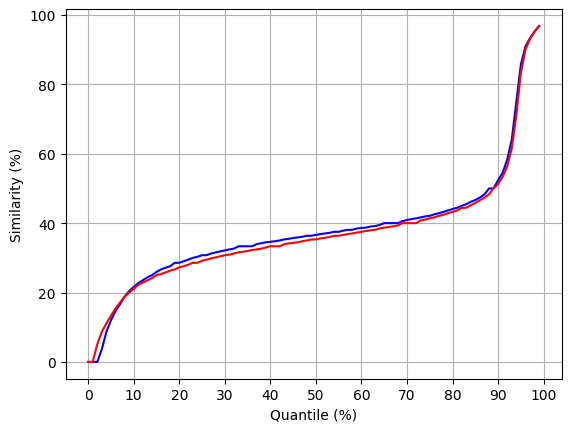

In [411]:
plt.plot(sim_l, color='blue')
plt.plot(sim_t, color='red')

plt.grid(True)

plt.xticks([i for i in range(0, 110, 10)])

plt.xlabel('Quantile (%)')
plt.ylabel('Similarity (%)')

plt.show()

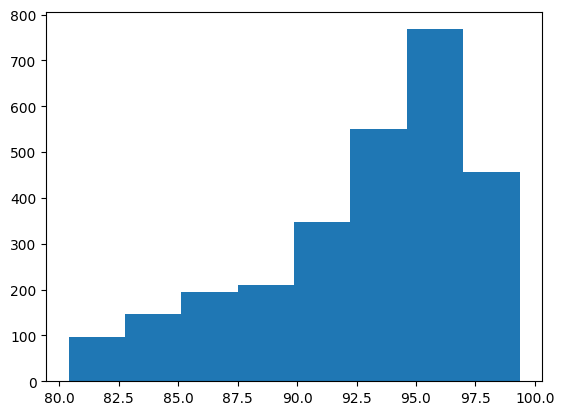

In [412]:
plt.hist(x=cross[cross.similarity > 80].similarity, bins=8)

plt.show()

In [413]:
cross.query('similarity > 80 & similarity < 90').sample(20)

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,similarity
739725,1701846,Days of Giants III,2024-01-07,82,<NA>,2024,1230881,Days of Giants,10.000,1,2024-01-07,50,82,3000,0.000,87.500000
24394,1022673,Teenage Hooker Became A Killing Machine In Dae...,2000-12-30,60,3.36,2000,76819,Teenage Hooker Became Killing Machine,4.406,16,2000-12-30,0,60,0,2.113,84.090909
283066,1276214,Go! Anpanman: Fluffy Flurry and the Land of Cl...,2021-06-25,63,<NA>,2021,691517,Go! Anpanman: Fluffy Fuwari and the Country of...,0.000,0,2021-06-25,0,63,0,1.554,85.436893
517825,1500072,"Sublime | 3 Ring Circus: Live at The Palace, H...",2013-06-18,80,<NA>,2013,376638,"Sublime: 3 Ring Circus - Live at The Palace, H...",0.000,0,2013-06-18,0,80,0,0.600,82.089552
207945,1203985,The Man with the Hispano,1933-03-24,85,<NA>,1933,354063,The Man in the Hispano-Suiza,0.000,0,1933-03-24,0,85,0,0.600,80.769231
45916,1043390,The Water-Carrier Is Dead,1977-11-20,103,3.81,1977,333290,The Water Carrier Died,7.500,6,1977-11-20,0,103,0,1.019,85.106383
401791,1387894,Ang Pagbabalik Ng Probinsyano,1998-02-08,123,<NA>,1998,496150,Pagbabalik ng Probinsyano,10.000,1,1998-02-08,0,123,0,0.684,88.888889
21412,1019718,#Home,2021-08-19,162,3.75,2021,859987,Home,7.800,22,2021-08-19,0,162,0,1.826,88.888889
554435,1533215,"once upon a time in 横浜 〜B'z LIVE GYM'99 ""Broth...",2000-08-02,115,<NA>,2000,984857,once upon a time in Yokohama ~B'z LIVE GYM'99 ...,0.000,0,2000-08-02,0,115,0,0.600,87.719298
40482,1039010,Baldwin's Nigger,1968-07-12,46,3.8,1968,207005,Baldwin's Ni**er,6.400,7,1968-07-12,0,46,0,1.717,87.500000


In [414]:
cross_over_80 = cross.query('similarity > 80')
cross_over_80

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,similarity
71,1000113,Spider-Man: Far from Home,2019-06-26,129,3.37,2019,429617,Spider-Man: Far From Home,7.447,14495,2019-06-28,1131927996,129,160000000,49.913,96.000000
139,1000188,Star Wars: Episode III – Revenge of the Sith,2005-05-17,140,3.82,2005,1895,Star Wars: Episode III - Revenge of the Sith,7.411,12753,2005-05-17,850000000,140,113000000,41.215,95.454545
186,1000223,Star Wars: Episode I – The Phantom Menace,1999-05-16,136,2.91,1999,1893,Star Wars: Episode I - The Phantom Menace,6.500,13550,1999-05-19,924317558,136,115000000,46.845,97.560976
189,1000229,The Godfather: Part II,1974-12-12,202,4.59,1974,240,The Godfather Part II,8.591,11293,1974-12-20,102600000,202,13000000,64.753,97.674419
237,1000282,Star Wars: Episode II – Attack of the Clones,2002-05-15,142,2.83,2002,1894,Star Wars: Episode II - Attack of the Clones,6.600,12288,2002-05-15,649398328,142,120000000,42.550,95.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046547,1920237,"Lucy, She’s No Lady!",2003-01-01,59,<NA>,2003,336260,Lucy - She’s No Lady!,0.000,0,2003-01-01,0,59,0,0.600,92.682927
1049839,1922335,Enfin ... Redde M'r Nimm Devun !,1974-12-31,134,<NA>,1974,413360,Enfin ... Redde M'r Nimm Devun,0.000,0,1974-12-31,0,134,0,0.600,96.774194
1050053,1922797,Kadkhoda's Daughter,1969-01-01,87,<NA>,1969,1259922,Kodkhona's Daughter,0.000,0,1969-01-01,0,87,0,0.000,89.473684
1050420,1932439,KYOTO BLACK: Red Woman,2019-11-25,97,<NA>,2019,1303800,KYOTO BLACK 4: Red Woman,0.000,0,2019-11-25,0,97,0,0.600,95.652174


In [415]:
print(f'Matched Letterboxd movies = {cross_over_80.id_letterboxd.nunique()}')
print(f'Matched TMDb movies = {cross_over_80.id_tmdb.nunique()}')

Matched Letterboxd movies = 2756
Matched TMDb movies = 2762


In [416]:
print(f'Left out Letterboxd movies = {unmatched_l.shape[0] - cross_over_80.id_letterboxd.nunique()}')
print(f'Left out TMDb movies = {unmatched_t.shape[0] - cross_over_80.id_tmdb.nunique()}')

Left out Letterboxd movies = 50121
Left out TMDb movies = 60984


In [417]:
cross_over_80 = cross_over_80.sort_values(by='similarity', ascending=False)

In [418]:
cross_over_80[cross_over_80.duplicated(subset=['id_tmdb'], keep=False)]

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,similarity
721790,1686358,The Beautiful Dead Face of a Pretty Girl: shelter,2002-09-24,60,<NA>,2002,1251540,The Beautiful Dead Face of a Pretty Girl: she...,0.000,0,2002-09-24,0,60,0,0.000,98.989899
72892,1065891,Pretty Guardian Sailor Moon Cosmos the Movie P...,2023-06-30,80,3.64,2023,968870,Pretty Guardian Sailor Moon Cosmos The Movie P...,10.000,1,2023-06-30,0,80,0,10.528,98.039216
69115,1062702,Pretty Guardian Sailor Moon Cosmos the Movie P...,2023-06-09,80,3.53,2023,968868,Pretty Guardian Sailor Moon Cosmos The Movie P...,8.833,6,2023-06-09,0,80,0,19.515,98.039216
6895,1006751,Gangs of Wasseypur – Part 1,2012-05-22,160,3.97,2012,117691,Gangs of Wasseypur - Part 1,7.147,324,2012-06-22,4100000,160,1400000,12.418,96.296296
8718,1008386,Gangs of Wasseypur – Part 2,2012-05-22,160,4.11,2012,126400,Gangs of Wasseypur - Part 2,7.900,82,2012-08-08,4900000,160,1670000,9.978,96.296296
69122,1062702,Pretty Guardian Sailor Moon Cosmos the Movie P...,2023-06-09,80,3.53,2023,968870,Pretty Guardian Sailor Moon Cosmos The Movie P...,10.000,1,2023-06-30,0,80,0,10.528,96.078431
72885,1065891,Pretty Guardian Sailor Moon Cosmos the Movie P...,2023-06-30,80,3.64,2023,968868,Pretty Guardian Sailor Moon Cosmos The Movie P...,8.833,6,2023-06-09,0,80,0,19.515,96.078431
447881,1433486,Johnny Cash: Live From Austin TX,2005-01-01,50,<NA>,2005,109021,Johnny Cash - Live From Austin TX,7.500,3,2005-01-01,0,50,0,0.600,95.384615
6896,1006751,Gangs of Wasseypur – Part 1,2012-05-22,160,3.97,2012,126400,Gangs of Wasseypur - Part 2,7.900,82,2012-08-08,4900000,160,1670000,9.978,92.592593
8717,1008386,Gangs of Wasseypur – Part 2,2012-05-22,160,4.11,2012,117691,Gangs of Wasseypur - Part 1,7.147,324,2012-06-22,4100000,160,1400000,12.418,92.592593


In [419]:
cross_over_80 = cross_over_80.drop_duplicates(subset=['id_tmdb'], keep='first')

In [420]:
print(f'Matched Letterboxd movies = {cross_over_80.id_letterboxd.nunique()}')
print(f'Matched TMDb movies = {cross_over_80.id_tmdb.nunique()}')

Matched Letterboxd movies = 2754
Matched TMDb movies = 2762


In [421]:
cross_over_80[cross_over_80.duplicated(subset=['id_letterboxd'], keep=False)]

,id_letterboxd,name,date,minute,rating,year,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,similarity
82226,1075504,Cheech & Chong's Animated Movie!,2013-04-18,84,2.93,2013,184322,Cheech & Chong's Animated Movie,5.300,19,2013-04-18,0,84,0,3.642,98.412698
93227,1088102,Louis C.K. : Back to the Garden,2023-01-28,70,3.66,2023,1123702,Louis C.K.: Back to the Garden,5.000,6,2023-01-28,0,70,0,0.892,98.360656
26025,1024364,Pretty Guardian Sailor Moon Eternal the Movie ...,2021-02-11,80,3.51,2021,784500,Pretty Guardian Sailor Moon Eternal The Movie ...,8.067,141,2021-02-11,0,80,0,17.462,98.076923
26024,1024364,Pretty Guardian Sailor Moon Eternal the Movie ...,2021-02-11,80,3.51,2021,618851,Pretty Guardian Sailor Moon Eternal The Movie ...,7.792,154,2021-01-08,0,80,0,15.899,96.153846
33684,1032782,Louis C.K. at The Dolby,2023-04-01,60,3.8,2023,1123257,Louis C.K. at the Dolby,6.400,8,2023-04-01,0,60,0,1.851,95.652174
446602,1432253,Superman - Super Villains: Metallo,2013-05-28,300,<NA>,2013,300384,Superman Super Villains : Metallo,6.000,3,2013-05-28,0,300,0,0.934,95.522388
93268,1088102,Louis C.K. : Back to the Garden,2023-01-28,70,3.66,2023,1356586,Louis CK: Back to the Garden,0.000,0,2023-01-28,0,70,0,0.600,94.915254
580130,1557677,Psychic Manjara 44,2024-02-02,50,<NA>,2024,1357696,Psychic Manjara 49,0.000,0,2024-11-02,0,50,0,0.000,94.444444
580129,1557677,Psychic Manjara 44,2024-02-02,50,<NA>,2024,1357663,Psychic Manjara 48,0.000,0,2024-10-02,0,50,0,1.400,94.444444
580086,1557677,Psychic Manjara 44,2024-02-02,50,<NA>,2024,1228824,Psychic Manjara 45,0.000,0,2024-03-06,0,50,0,0.604,94.444444


In [422]:
cross_over_80 = cross_over_80.drop_duplicates(subset=['id_letterboxd'], keep='first')

In [423]:
print(f'Matched Letterboxd movies = {cross_over_80.id_letterboxd.nunique()}')
print(f'Matched TMDb movies = {cross_over_80.id_tmdb.nunique()}')

Matched Letterboxd movies = 2754
Matched TMDb movies = 2754


# Unified ID: Part 2

To concatenate these two dataframes and create a final, unified dataframe with unified id, we need to keep only the relevant columns.

In [424]:
print(cross_over_80.columns)
print(inner.columns)

Index(['id_letterboxd', 'name', 'date', 'minute', 'rating', 'year', 'id_tmdb',
       'title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'budget', 'popularity', 'similarity'],
      dtype='object')
Index(['id_letterboxd', 'name', 'date', 'minute', 'rating', 'year_letterboxd',
       'id_tmdb', 'title', 'vote_average', 'vote_count', 'release_date',
       'revenue', 'runtime', 'budget', 'popularity', 'year_tmdb',
       'year_difference'],
      dtype='object')


In [425]:
intersect = cross_over_80.columns.intersection(inner.columns)
intersect

Index(['id_letterboxd', 'name', 'date', 'minute', 'rating', 'id_tmdb', 'title',
       'vote_average', 'vote_count', 'release_date', 'revenue', 'runtime',
       'budget', 'popularity'],
      dtype='object')

In [426]:
cross_over_80[intersect]

,id_letterboxd,name,date,minute,rating,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity
89534,1084191,Classic Albums: Sex Pistols - Never Mind The B...,2002-11-19,88,3.53,37756,Classic Albums : Sex Pistols - Never Mind The ...,7.200,10,2002-11-19,0,88,0,1.768
105676,1101309,Frankie Boyle: If I Could Reach Out Through Yo...,2010-11-09,70,3.58,49614,Frankie Boyle: If I Could Reach Out Through Yo...,6.600,18,2010-11-09,0,70,0,1.280
47781,1045312,Senritsu Kaiki File Kowasugi! Preface: True St...,2014-04-02,71,3.47,854907,Senritsu Kaiki File Kowasugi! Preface: True St...,6.667,3,2014-04-02,0,71,0,0.845
793722,1743629,Tides: A History of Lives and Dreams Lost and ...,2016-06-21,40,<NA>,443273,Tides: A History of Lives and Dreams Lost and ...,0.000,0,2016-06-21,0,40,0,0.600
34036,1033093,Psycho-Pass: Sinners of the System - Case.1 Cr...,2019-01-25,60,3.3,510242,Psycho-Pass: Sinners of the System - Case.1 C...,6.703,69,2019-01-25,0,60,0,11.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292553,1284734,Highlander: Unholy Alliance,1994-02-21,95,<NA>,344487,Highlander: The Series - Unholy Alliance,4.000,1,1994-02-21,0,95,0,1.575
575649,1553513,Così fan tutte - Salzburger Festspiele 2020,2020-08-06,154,<NA>,790135,Così fan tutte — Salzburg Festival,0.000,0,2020-08-06,0,154,0,0.973
127745,1125283,Banned from Broadcast 2: The Cursed Large Family,2003-06-07,45,<NA>,840314,Banned from Broadcast 2: A Damned Big Family,0.000,0,2003-06-07,0,45,0,0.600
337487,1328536,Toku: Touken Ranbu: Hanamaru ~Setsugetsuka~ Y...,2022-05-20,73,<NA>,978039,Toku Touken Ranbu Hanamaru: Yuki no Maki,6.000,1,2022-05-20,0,73,0,2.478


In [427]:
inner[intersect]

,id_letterboxd,name,date,minute,rating,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity
0,1000001,Barbie,2023-07-06,114,3.86,346698,Barbie,7.279,5074,2023-07-19,1428545028,114,145000000,1069.340
1,1000002,Parasite,2019-05-21,133,4.56,496243,Parasite,8.515,16430,2019-05-30,257591776,133,11363000,64.627
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3,545611,Everything Everywhere All at Once,7.822,5210,2022-03-24,139200000,140,25000000,64.278
3,1000004,Fight Club,1999-09-10,139,4.27,550,Fight Club,8.438,27238,1999-10-15,100853753,139,63000000,69.498
4,1000005,La La Land,2016-08-31,129,4.09,313369,La La Land,7.897,15625,2016-11-29,447407695,129,30000000,32.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391789,1941251,Khaitseli,2024-04-05,98,<NA>,1306802,Khaitseli,0.000,0,2024-04-05,0,98,0,0.600
391790,1941252,Kira Carpelan,2007-12-31,78,<NA>,1306682,Kira Carpelan,0.000,0,2007-12-31,0,78,0,0.600
391791,1941298,Mangue: Uma Parte Da Raiz,2010-12-03,31,<NA>,1306618,Mangue: Uma Parte Da Raiz,0.000,0,2010-12-03,0,31,0,0.903
391792,1941424,Sex Demon,1975-01-01,58,<NA>,1306787,Sex Demon,0.000,0,1975-01-01,0,58,0,0.600


In [428]:
unified = pd.concat([inner[intersect], cross_over_80[intersect]], axis=0, ignore_index=True)
unified

,id_letterboxd,name,date,minute,rating,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity
0,1000001,Barbie,2023-07-06,114,3.86,346698,Barbie,7.279,5074,2023-07-19,1428545028,114,145000000,1069.340
1,1000002,Parasite,2019-05-21,133,4.56,496243,Parasite,8.515,16430,2019-05-30,257591776,133,11363000,64.627
2,1000003,Everything Everywhere All at Once,2022-03-11,140,4.3,545611,Everything Everywhere All at Once,7.822,5210,2022-03-24,139200000,140,25000000,64.278
3,1000004,Fight Club,1999-09-10,139,4.27,550,Fight Club,8.438,27238,1999-10-15,100853753,139,63000000,69.498
4,1000005,La La Land,2016-08-31,129,4.09,313369,La La Land,7.897,15625,2016-11-29,447407695,129,30000000,32.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393133,1284734,Highlander: Unholy Alliance,1994-02-21,95,<NA>,344487,Highlander: The Series - Unholy Alliance,4.000,1,1994-02-21,0,95,0,1.575
393134,1553513,Così fan tutte - Salzburger Festspiele 2020,2020-08-06,154,<NA>,790135,Così fan tutte — Salzburg Festival,0.000,0,2020-08-06,0,154,0,0.973
393135,1125283,Banned from Broadcast 2: The Cursed Large Family,2003-06-07,45,<NA>,840314,Banned from Broadcast 2: A Damned Big Family,0.000,0,2003-06-07,0,45,0,0.600
393136,1328536,Toku: Touken Ranbu: Hanamaru ~Setsugetsuka~ Y...,2022-05-20,73,<NA>,978039,Toku Touken Ranbu Hanamaru: Yuki no Maki,6.000,1,2022-05-20,0,73,0,2.478


In [429]:
subset = ['name', 'date']
unified[unified.duplicated(subset=subset, keep=False)]

,id_letterboxd,name,date,minute,rating,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity


In [430]:
subset = ['title', 'release_date']
unified[unified.duplicated(subset=subset, keep=False)]

,id_letterboxd,name,date,minute,rating,id_tmdb,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity


# Final outputs

In [431]:
movies = unified[['id_letterboxd', 'name', 'minute']].copy()
movies.rename(columns={'id_letterboxd': 'id'}, inplace=True)
movies

,id,name,minute
0,1000001,Barbie,114
1,1000002,Parasite,133
2,1000003,Everything Everywhere All at Once,140
3,1000004,Fight Club,139
4,1000005,La La Land,129
...,...,...,...
393133,1284734,Highlander: Unholy Alliance,95
393134,1553513,Così fan tutte - Salzburger Festspiele 2020,154
393135,1125283,Banned from Broadcast 2: The Cursed Large Family,45
393136,1328536,Toku: Touken Ranbu: Hanamaru ~Setsugetsuka~ Y...,73


In [432]:
if REPLICATION:
    movies.to_csv('./output/movies.csv', index=False)

In [433]:
money = unified[['id_letterboxd', 'revenue', 'budget']].copy()
money.rename(columns={'id_letterboxd': 'id'}, inplace=True)
money

,id,revenue,budget
0,1000001,1428545028,145000000
1,1000002,257591776,11363000
2,1000003,139200000,25000000
3,1000004,100853753,63000000
4,1000005,447407695,30000000
...,...,...,...
393133,1284734,0,0
393134,1553513,0,0
393135,1125283,0,0
393136,1328536,0,0


In [438]:
money.query('revenue > 0')

,id,revenue,budget
0,1000001,1428545028,145000000
1,1000002,257591776,11363000
2,1000003,139200000,25000000
3,1000004,100853753,63000000
4,1000005,447407695,30000000
...,...,...,...
393005,1003999,10882920,0
393006,1004140,2826523,4000000
393029,1035306,1600000,700000
393033,1063575,11067556,0


In [439]:
money.query('budget > 0')

,id,revenue,budget
0,1000001,1428545028,145000000
1,1000002,257591776,11363000
2,1000003,139200000,25000000
3,1000004,100853753,63000000
4,1000005,447407695,30000000
...,...,...,...
393012,1265383,0,1200000
393014,1177162,0,34000
393020,1022110,0,6000000
393029,1035306,1600000,700000


In [440]:
money.query('revenue > 0 and budget > 0')

,id,revenue,budget
0,1000001,1428545028,145000000
1,1000002,257591776,11363000
2,1000003,139200000,25000000
3,1000004,100853753,63000000
4,1000005,447407695,30000000
...,...,...,...
392750,1701846,50,3000
392872,1054067,3,600
392995,1077210,29694624,7000000
393006,1004140,2826523,4000000


In [434]:
if REPLICATION:
    money.to_csv('./output/money.csv', index=False)

In [435]:
ratings = unified[['id_letterboxd', 'rating', 'vote_average', 'vote_count', 'popularity']].copy()
ratings.rename(columns={'id_letterboxd': 'id'}, inplace=True)
#Convert ratings to 0-10 scale
ratings['rating'] = ratings['rating']*2
ratings

,id,rating,vote_average,vote_count,popularity
0,1000001,7.72,7.279,5074,1069.340
1,1000002,9.12,8.515,16430,64.627
2,1000003,8.6,7.822,5210,64.278
3,1000004,8.54,8.438,27238,69.498
4,1000005,8.18,7.897,15625,32.009
...,...,...,...,...,...
393133,1284734,<NA>,4.000,1,1.575
393134,1553513,<NA>,0.000,0,0.973
393135,1125283,<NA>,0.000,0,0.600
393136,1328536,<NA>,6.000,1,2.478


In [443]:
ratings[~((ratings.rating.isna()) & (ratings.vote_average == 0))]

,id,rating,vote_average,vote_count,popularity
0,1000001,7.72,7.279,5074,1069.340
1,1000002,9.12,8.515,16430,64.627
2,1000003,8.6,7.822,5210,64.278
3,1000004,8.54,8.438,27238,69.498
4,1000005,8.18,7.897,15625,32.009
...,...,...,...,...,...
393128,1098223,7.5,8.000,1,1.400
393130,1067238,6.04,4.600,52,3.389
393132,1379635,<NA>,10.000,1,1.120
393133,1284734,<NA>,4.000,1,1.575


In [436]:
if REPLICATION:
    ratings.to_csv('./output/ratings.csv', index=False)

# Removing dropped ids from other files

In [437]:
if REPLICATION:
    movies = pd.read_csv('./output/movies.csv')
    valid_ids = set(movies.id)

    directory = Path("./output")

    for file in directory.iterdir():
        if file.is_file() and file.name != 'movies.csv':
            df = pd.read_csv(file)
            df = df[df.id.isin(valid_ids)]
            df.to_csv(f'./target/{file.name}', index=False)